In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("seaborn")
import requests
from pyproj import Proj, transform
import tqdm
import concurrent.futures
import requests
import time


# Load data

In [336]:
boucherville_2013 = pd.read_csv("data/OD13_amtSm_309.csv")
longueuilEst_2013 = pd.read_csv("data/OD13_amtSm_302.csv")
saintBruno_2013 = pd.read_csv("data/OD13_amtSm_310.csv")
#suburb = pd.concat([boucherville_2013, longueuilEst_2013, saintBruno_2013])
suburb_2013 = pd.read_csv("data/OD13_suburb_with_walkscore.csv")
suburb_2013.title = "Banlieue 2013"

boucherville_2003 = pd.read_csv("data/OD03_amtSm_309.csv")
longueuilEst_2003 = pd.read_csv("data/OD03_amtSm_302.csv")
saintBruno_2003 = pd.read_csv("data/OD03_amtSm_310.csv")
suburb_2003 = pd.concat([boucherville_2003, longueuilEst_2003, saintBruno_2003])
suburb_2003.title = "Banlieue 2003"

#montrealNord = pd.read_csv("data/OD13_amtSm_118.csv")
montrealNord = pd.read_csv("data/OD13_montrealNord_with_walkscore.csv")
montrealNord.title = "Montréal-Nord"

#plateau = pd.read_csv("data/OD13_amtSm_106.csv")
montrealNord = pd.read_csv("data/OD13_plateau_with_walkscore.csv")
plateau.title = "Le Plateau Mont-Royal"

EPOI_2013_Boucherville = pd.read_csv("data/EPOI2013Sm_309.csv")

In [8]:
# NAD 83 to lat long
from pyproj import Transformer
transformer = Transformer.from_crs("epsg:32188", "epsg:4326", always_xy=True)

## WalkScore

In [9]:
exit_early = True

In [10]:
def load_url(url, feuillet_id, timeout=20):
    ans = requests.get(url, timeout=timeout)
    json_output = ans.json()
    #json_output = {"walkscore": feuillet_id}
    return feuillet_id, ans, json_output

def calculate_walk_score(df, exit_early=True):
    futures = []
    
    if exit_early:
        return
    warning = input("Warning!!! Are you sure ? ").lower()

    if warning != "y":
        print("bye")
        return

    feuillet_ids = df.feuillet.unique()
    with tqdm.tqdm(total=len(feuillet_ids)) as progress_bar:
        with concurrent.futures.ThreadPoolExecutor(max_workers=9) as executor:
            for feuillet_id in feuillet_ids:                
                x_domi = (df[df.feuillet == feuillet_id].xdomi).iloc[0]
                y_domi = (df[df.feuillet == feuillet_id].ydomi).iloc[0]
                x_domi, y_domi = transformer.transform(int(x_domi), int(y_domi))
                rows = df[df.feuillet == feuillet_id]
                url = f"https://api.walkscore.com/score?format=json&transit=1&bike=1&lon={x_domi}&lat={y_domi}&wsapikey=2845bc34690754d7389df25eabeb8ce9"
                #url = "https://jsonplaceholder.typicode.com/todos/1"
                futures.append(executor.submit(load_url, url, feuillet_id))

            for future in concurrent.futures.as_completed(futures):
                feuillet_id, ans, json_resp = future.result()
                if ans.status_code != 200:
                    print(f"{feuillet_id}, {json_resp}")

                walk_score = json_resp.get("walkscore", -1)
                bike_score = json_resp.get("bike", {}).get("score", -1)
                transit_score = json_resp.get("transit", {}).get("score", -1)

                # Store the data
                df.loc[df.feuillet == feuillet_id, 'walkscore'] = walk_score
                df.loc[df.feuillet == feuillet_id, 'bikescore'] = bike_score
                df.loc[df.feuillet == feuillet_id, 'transitscore'] = transit_score

                progress_bar.update(1)


In [11]:
calculate_walk_score(suburb, exit_early=exit_early)
#suburb.to_csv("data/OD13_suburb_with_walkscore.csv")

In [135]:
calculate_walk_score(montrealNord, exit_early=exit_early)
#montrealNord.to_csv("data/OD13_montrealNord_with_walkscore.csv")

Warning!!! Are you sure ? y


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1475/1475 [01:31<00:00, 16.12it/s]


In [136]:
calculate_walk_score(plateau, exit_early=exit_early)
#plateau.to_csv("data/OD13_plateau_with_walkscore.csv")

Warning!!! Are you sure ? y


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1946/1946 [02:08<00:00, 15.20it/s]


# Typologies

## Personnes

In [96]:
def pers_typology(df, typology_number):
    if typology_number == 1:   # Typologie 1: femmes, 20-29 ans, pas de permis
        return df[(df.f_pers == "T") 
            & (df.genre == 1) 
            & (df.p_statut == 1) 
            & (df.age >= 60) 
            & (df.age <= 69)
            & (df.permis == 1)]
    elif typology_number == 2: # Typologie 2: hommes, 20-29 ans, étudiants
        return df[(df.f_pers == "T") 
            & (df.genre == 1) 
            & (df.p_statut == 3) 
            & (df.age >= 20) 
            & (df.age <= 29)]
    elif typology_number == 3: # Typologie 3: hommes, 60-69 ans, retraités
        return df[(df.f_pers == "T") 
            & (df.genre == 1) 
            & (df.p_statut == 4) 
            & (df.age >= 60) 
            & (df.age <= 69)]
    elif typology_number == 4: # Typologie 4: femmes, 40-49 ans, travailleuses à temps plein
        return df[(df.f_pers == "T") 
            & (df.genre == 2) 
            & (df.p_statut == 1) 
            & (df.age >= 40) 
            & (df.age <= 49)]
    elif typology_number == 5: # Typologie 5: femmes, 10-19 ans, étudiantes, pas de permis
        return df[(df.f_pers == "T") 
            & (df.genre == 2) 
            & (df.p_statut == 3) 
            & (df.age >= 10) 
            & (df.age <= 19)
            & (df.permis == 2)]
    elif typology_number == 6: # Typologie 6: Hommes, 60-69 ans, travailleurs à temps plein, avec permis
        return df[(df.f_pers == "T") 
            & (df.genre == 1) 
            & (df.p_statut == 1) 
            & (df.age >= 60) 
            & (df.age <= 69)
            & (df.permis == 1)]

In [6]:
def calculate_pers_typology_obs_size(df):
    print(f"=== {df.title} ===")
    # Make sure this is only the people DB
    df_ = df[df["f_pers"] == 'T']
    
    for i in [1, 2, 3, 4, 5, 6]:
        facper_share = pers_typology(df_, i).facper.sum() / df_.facper.sum()
        print(f"Typologie {i}: {len(pers_typology(df_, i))} {facper_share * 100:0.2f} %")

In [7]:
calculate_pers_typology_obs_size(suburb)
calculate_pers_typology_obs_size(montrealNord)
calculate_pers_typology_obs_size(plateau)

=== Banlieue ===
Typologie 1: 102 1.49 %
Typologie 2: 104 2.35 %
Typologie 3: 295 3.77 %
Typologie 4: 346 6.38 %
Typologie 5: 83 1.46 %
Typologie 6: 102 1.49 %
=== Montréal-Nord ===
Typologie 1: 40 0.97 %
Typologie 2: 38 1.66 %
Typologie 3: 119 2.58 %
Typologie 4: 135 4.07 %
Typologie 5: 49 1.70 %
Typologie 6: 40 0.97 %
=== Le Plateau Mont-Royal ===
Typologie 1: 58 1.01 %
Typologie 2: 90 3.78 %
Typologie 3: 131 2.27 %
Typologie 4: 230 4.53 %
Typologie 5: 62 1.07 %
Typologie 6: 58 1.01 %


## Ménages

In [374]:
def add_children_column(df):
    for feuillet_id in df.feuillet.unique():
        rows = df[df.feuillet == feuillet_id]
        people_in_household = rows[rows.f_pers == "T"]
        children_count = len(people_in_household[people_in_household.age <= 17])
        df.loc[df.feuillet == feuillet_id, 'children'] = children_count
    df['children'] = df['children'].astype(int)
def add_drivers_column(df):
    for feuillet_id in df.feuillet.unique():
        rows = df[df.feuillet == feuillet_id]
        people_in_household = rows[rows.f_pers == "T"]
        drivers_count = len(people_in_household[people_in_household.permis == 1])
        df.loc[df.feuillet == feuillet_id, 'drivers'] = drivers_count

    df['drivers'] = df['drivers'].astype(int)
def add_retired_column(df):
    for feuillet_id in df.feuillet.unique():
        rows = df[df.feuillet == feuillet_id]
        people_in_household = rows[rows.f_pers == "T"]
        retired_count = len(people_in_household[people_in_household.p_statut == 4])
        df.loc[df.feuillet == feuillet_id, 'retired'] = retired_count
    df['retired'] = df['retired'].astype(int)
def add_trip_distance_column(df):
    df['trip_distance'] = np.sqrt((df.xdest - df.xorig) **2 + (df.ydest - df.yorig)**2)

for df in tqdm.tqdm([suburb_2013, suburb_2003, montrealNord, plateau]):
    add_children_column(df)
    add_drivers_column(df)
    add_retired_column(df)
    add_trip_distance_column(df)


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 264.32it/s]


In [9]:
def menages_typology(df, typology):
    if typology == 1: # Typologie 1: min 1 enfant, pas d'automobiles
        return df[(df.f_menage == "T") 
                & (df.children >= 1)
                & (df.autologi == 0)
                ]
    elif typology == 2: # Typologie 2: 4+ logis, 2 enfants+, 2 autos+
        return df[(df.f_menage == "T")
                & (df.perslogi >= 2)
                & (df.children >= 2)
                & (df.autologi >= 2)
                ]
    elif typology == 3: # Typologie 3: Full car access : Nb drivers = Nb automobiles
        return df[(df.f_menage == "T") 
                & (df.autologi == df.drivers)
                ]
    elif typology == 4: # Typologie 4: "The seemingly rich" : >cars than drivers
        return df[(df.f_menage == "T") 
                & (df.autologi > df.drivers)
                ]
    elif typology == 5: # Typologie 5: Couples sans enfants (ou colocataires)
        return df[(df.f_menage == "T") 
                & (df.children == 0)
                & (df.perslogi == 2)
                ]
    elif typology == 6: # Typologie 6: Couple de retraités ayant chacun un permis de conduire
        return df[(df.f_menage == "T") 
                & (df.perslogi == 2)
                & (df.retired == 2)
                & (df.drivers == 2)
                ]

In [10]:
def calculate_household_typology_obs_size(df):
    print(f"=== {df.title} ===")
    # Make sure this is only the household DB
    df_ = df[df["f_menage"] == 'T']
    
    for i in [1, 2, 3, 4, 5, 6]:
        fshare = menages_typology(df_, i).faclog.sum() / df_.faclog.sum()
        print(f"Typologie {i}: {len(menages_typology(df_, i))} {round(fshare * 100, 2):0.2f} %")

In [11]:
calculate_household_typology_obs_size(suburb)
calculate_household_typology_obs_size(montrealNord)
calculate_household_typology_obs_size(plateau)

=== Banlieue ===
Typologie 1: 41 2.01 %
Typologie 2: 343 13.29 %
Typologie 3: 1175 50.16 %
Typologie 4: 233 9.70 %
Typologie 5: 778 27.55 %
Typologie 6: 237 7.88 %
=== Montréal-Nord ===
Typologie 1: 54 4.00 %
Typologie 2: 68 4.55 %
Typologie 3: 1023 69.43 %
Typologie 4: 59 4.25 %
Typologie 5: 461 27.03 %
Typologie 6: 87 4.60 %
=== Le Plateau Mont-Royal ===
Typologie 1: 106 3.91 %
Typologie 2: 23 0.66 %
Typologie 3: 892 47.89 %
Typologie 4: 40 2.14 %
Typologie 5: 571 29.01 %
Typologie 6: 46 1.82 %


## Voisinages

In [12]:
def calc(df):
    master = df[df.f_menage == "T"]
    for feuillet_id in master.feuillet.unique():
        x_domi = master[master.feuillet == feuillet_id].xdomi
        y_domi = master[master.feuillet == feuillet_id].ydomi
        print(x_domi, y_domi)

        x_domi, y_domi = transformer.transform(int(x_domi), int(y_domi))
        print(x_domi, y_domi)
        break
        rows = df[df.feuillet == feuillet_id]

        #for idx in rows.index:
        #    df.at[idx, 'drivers'] = drivers_count
calc(suburb)

0    309320
Name: xdomi, dtype: int64 0    5050582
Name: ydomi, dtype: int64
-73.44206505103081 45.59512804406428


In [13]:
suburb[(suburb.feuillet == 1000282) & (suburb.f_menage == "T")].ydomi

2    5051267
Name: ydomi, dtype: int64

# Tâche #2

[10.37767562 12.50983111 10.80142697 11.41497875 14.8633178  16.33509275
 12.60862259  8.20242312  2.6569537   0.22967758]
[11.05167269 13.84339846 11.78566454 13.66042676 18.88124172 14.66641621
  9.66614158  4.79089681  1.46936289  0.18477835]


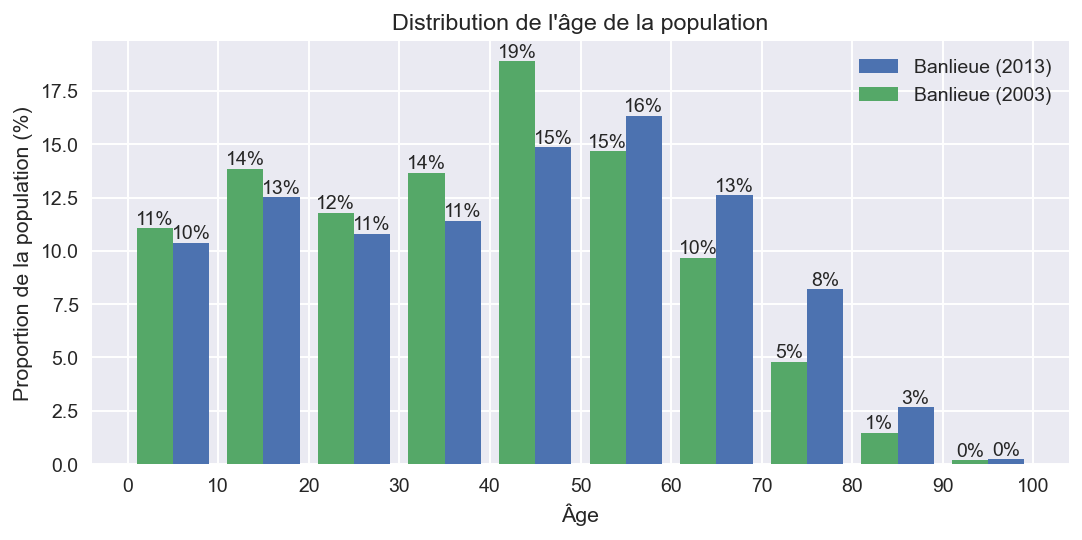

In [337]:
width = 4
plt.figure(figsize=(9, 4), dpi=140)
def age_plot(df, title, offset):
    df_people = df[df["f_pers"] == 'T']

    total_facper = df_people.facper.sum()

    age_bin_edges = np.array([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    age_bins = np.histogram(list(df_people.age), bins=age_bin_edges, weights=df_people.facper / total_facper * 100)[0]
    print(age_bins)
    
    bar = plt.bar(age_bin_edges[:-1]-offset+5, age_bins, width=width, label=title)
    plt.bar_label(bar, fmt="%.0f%%")
    _ = plt.xticks(age_bin_edges)
    plt.xlabel("Âge")
    plt.ylabel("Proportion de la population (%)")
    plt.title("Distribution de l'âge de la population")
age_plot(suburb_2013, title="Banlieue (2013)", offset=-width/2)
age_plot(suburb_2003, title="Banlieue (2003)", offset=width/2)
plt.legend()


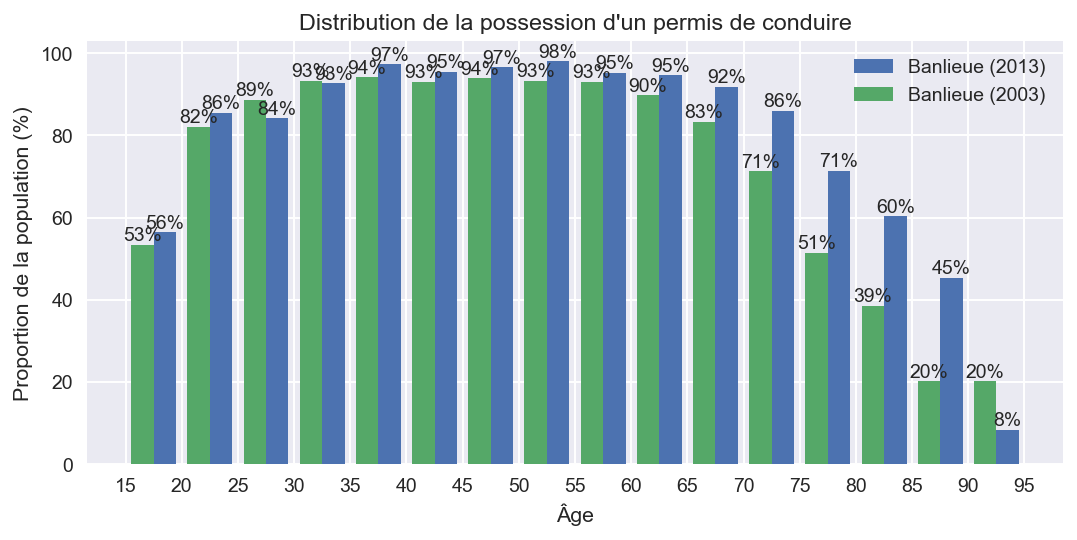

In [367]:
width = 2
plt.figure(figsize=(9, 4), dpi=140)
def drivers_plot(df, title, offset):
    bins = np.arange(15, 100, 5)
    df["age_cut"] = pd.cut(df["age"], bins)

    df_people = df[df["f_pers"] == 'T']
    drivers_rate = df_people[df_people["permis"] == 1].groupby("age_cut").sum()["facper"] / df_people.groupby("age_cut").sum()["facper"] * 100
    
    bar = plt.bar(bins[:-1]+2.5-offset, drivers_rate, width=width, label=title)
    plt.bar_label(bar, fmt="%.0f%%")
    _ = plt.xticks(bins)
    plt.xlabel("Âge")
    plt.ylabel("Proportion de la population (%)")
    plt.title("Distribution de la possession d'un permis de conduire")
drivers_plot(suburb_2013, title="Banlieue (2013)", offset=-width/2)
drivers_plot(suburb_2003, title="Banlieue (2003)", offset=width/2)
plt.legend()



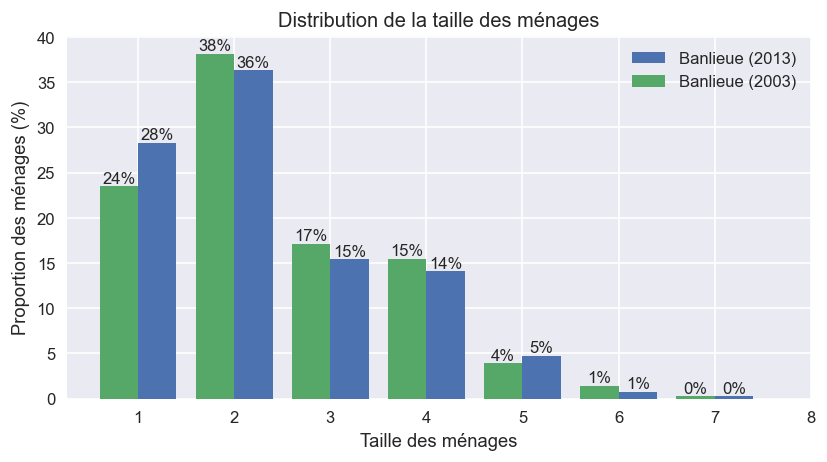

In [228]:
width = 0.4
plt.figure(figsize=(8, 4), dpi=120)
def age_plot(df, title, offset):
    df_households = df[df["f_menage"] == 'T']

    total_faclog = df_households.faclog.sum()

    bin_edges = np.array([1, 2, 3, 4, 5, 6, 7, 8])
    bins = np.histogram(list(df_households.perslogi), bins=bin_edges, weights=df_households.faclog / total_faclog * 100)[0]
    
    bar = plt.bar(bin_edges[:-1]-offset, bins, width=width, align="center", label=title)
    plt.bar_label(bar, fmt="%.0f%%")
    _ = plt.xticks(bin_edges)
    plt.xlabel("Taille des ménages")
    plt.ylabel("Proportion des ménages (%)")
    plt.title("Distribution de la taille des ménages")
age_plot(suburb_2013, title="Banlieue (2013)", offset=-width/2)
age_plot(suburb_2003, title="Banlieue (2003)", offset=width/2)
plt.legend()



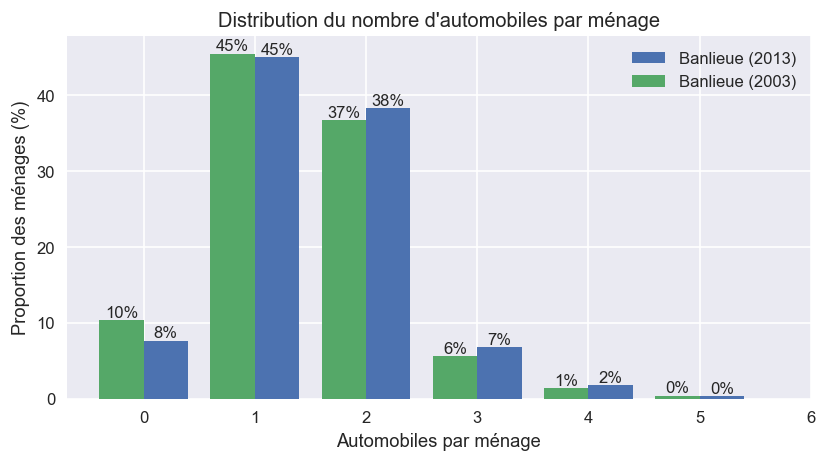

In [231]:
width = 0.4
plt.figure(figsize=(8, 4), dpi=120)
def age_plot(df, title, offset):
    df_households = df[df["f_menage"] == 'T']

    total_faclog = df_households.faclog.sum()

    bin_edges = np.array([0, 1, 2, 3, 4, 5, 6])
    bins = np.histogram(list(df_households.autologi), bins=bin_edges, weights=df_households.faclog / total_faclog * 100)[0]
    
    bar = plt.bar(bin_edges[:-1]-offset, bins, width=width, align="center", label=title)
    plt.bar_label(bar, fmt="%.0f%%")
    _ = plt.xticks(bin_edges)
    plt.xlabel("Automobiles par ménage")
    plt.ylabel("Proportion des ménages (%)")
    plt.title("Distribution du nombre d'automobiles par ménage")
age_plot(suburb_2013, title="Banlieue (2013)", offset=-width/2)
age_plot(suburb_2003, title="Banlieue (2003)", offset=+width/2)
plt.legend()


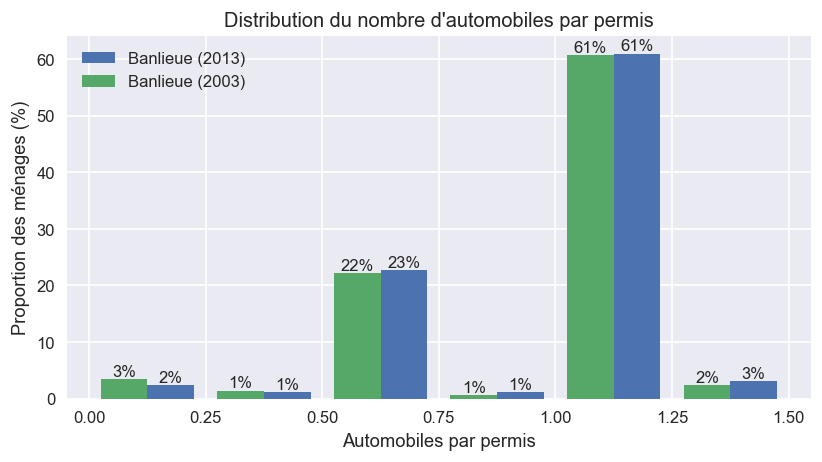

In [232]:
width = 0.10
plt.figure(figsize=(8, 4), dpi=120)
def age_plot(df, title, offset):
    df_households = df[df["f_menage"] == 'T']

    total_faclog = df_households.faclog.sum()

    bin_edges = np.array([0, 0.25, 0.50, 0.75, 1.00, 1.25, 1.5])
    bins = np.histogram(list(df_households.autologi / df_households.drivers), bins=bin_edges, weights=df_households.faclog / total_faclog * 100)[0]
    
    bar = plt.bar(bin_edges[:-1]-offset+0.125, bins, width=width, align="center", label=title)
    plt.bar_label(bar, fmt="%.0f%%")
    _ = plt.xticks(bin_edges)
    plt.xlabel("Automobiles par permis")
    plt.ylabel("Proportion des ménages (%)")
    plt.title("Distribution du nombre d'automobiles par permis")
age_plot(suburb_2013, title="Banlieue (2013)", offset=-width/2)
age_plot(suburb_2003, title="Banlieue (2003)", offset=+width/2)
plt.legend()



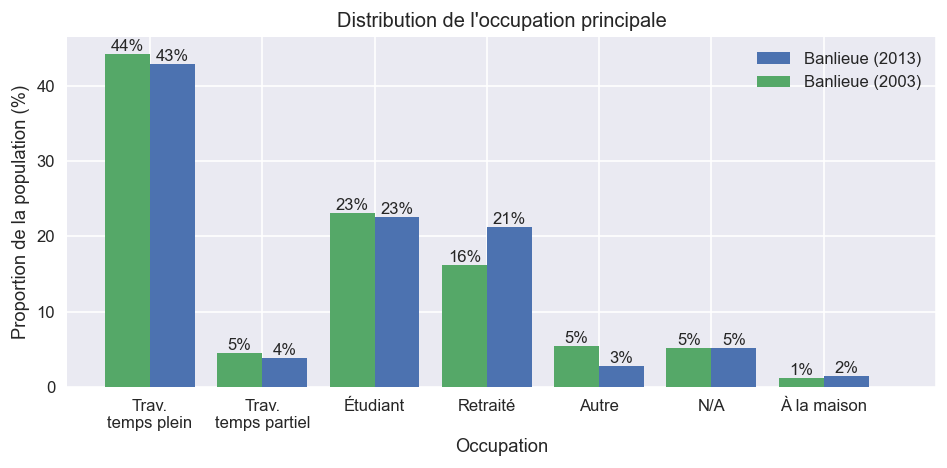

In [236]:
width = 0.4
plt.figure(figsize=(8, 4), dpi=120)
def age_plot(df, title, offset):
    df_people = df[df["f_pers"] == 'T']

    total_facper = df_people.facper.sum()

    age_bin_edges = np.array([1, 2, 3, 4, 5, 6, 7, 8])
    age_bins = np.histogram(list(df_people.p_statut), bins=age_bin_edges, weights=df_people.facper / total_facper * 100)[0]
    
    bar = plt.bar(age_bin_edges[:-1]-offset, age_bins, width=width, label=title)
    plt.bar_label(bar, fmt="%.0f%%")

    _ = plt.xticks(age_bin_edges, ["Trav.\ntemps plein", "Trav.\ntemps partiel", "Étudiant", "Retraité", "Autre", "N/A", "À la maison", ""])
    plt.xlabel("Occupation")
    plt.ylabel("Proportion de la population (%)")
    plt.title("Distribution de l'occupation principale")
age_plot(suburb_2013, title="Banlieue (2013)", offset=-width/2)
age_plot(suburb_2003, title="Banlieue (2003)", offset=+width/2)
plt.tight_layout()
plt.legend()



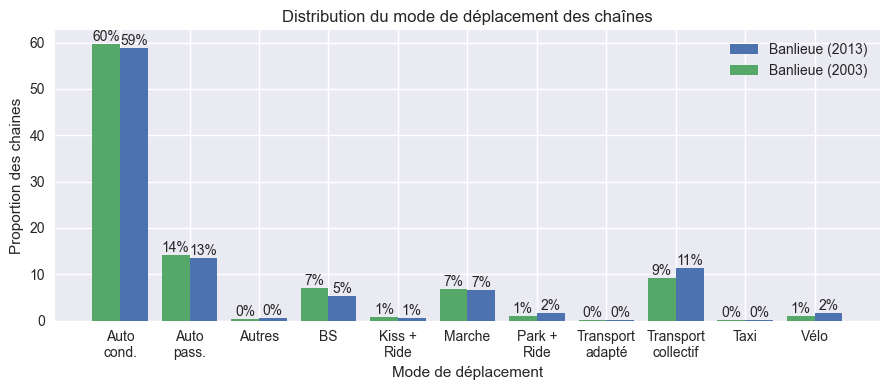

In [238]:
width = 0.4
plt.figure(figsize=(9, 4), dpi=100)
def _plot(df, title, offset):
    df_chaines = df[df["f_chaine"] == 'T']

    total_facper = df_chaines.facper.sum()

    modes = (df_chaines.groupby("mode").sum()["facper"] / total_facper.sum() * 100)
    modes = list(modes)
    xvals = np.arange(0, len(modes))
    bar = plt.bar(xvals-offset, modes, width=width, label=title)
    plt.bar_label(bar, fmt="%.0f%%")

    _ = plt.xticks(xvals, ["Auto\ncond.",
                           "Auto\npass.",
                           "Autres", 
                           "BS",
                           "Kiss +\nRide",
                           'Marche',
                           "Park +\nRide",
                           'Transport\nadapté', 
                           "Transport\ncollectif",
                           'Taxi', 
                           "Vélo",
                          ])
    plt.xlabel("Mode de déplacement")
    plt.ylabel("Proportion des chaines")
    plt.title("Distribution du mode de déplacement des chaînes")
_plot(suburb_2013, title="Banlieue (2013)", offset=-width/2)
_plot(suburb_2003, title="Banlieue (2003)", offset=+width/2)
plt.tight_layout()
plt.legend()


15
15


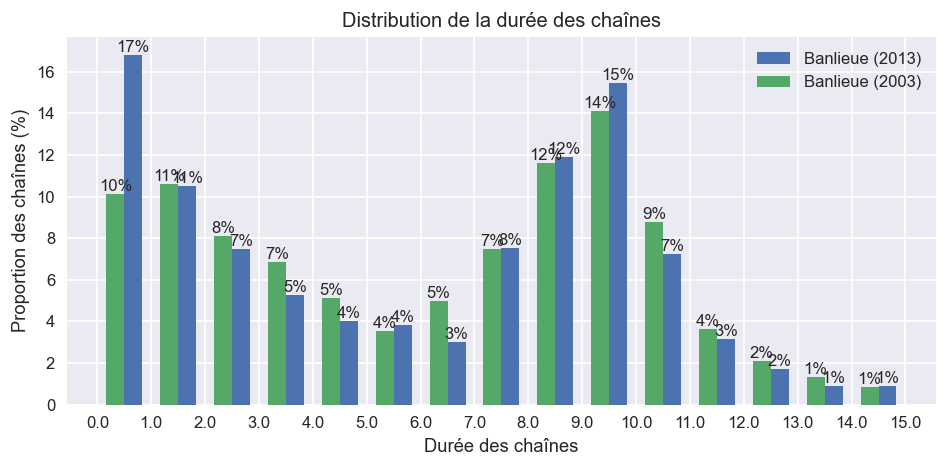

In [275]:
width = 20
plt.figure(figsize=(8, 4), dpi=120)
def length_plot(df, title, offset):
    df_chaine = df[df["f_chaine"] == 'T']

    total_facper = df_chaine.facper.sum()

    bin_edges = np.arange(0, 960, 60) # 0 to 900 minutes with 60 minute increments
    bins = np.histogram(list(df_chaine.ch_duree), bins=bin_edges, weights=df_chaine.facper / total_facper * 100)[0]

    print(len(bins))
    bar = plt.bar(bin_edges[:-1]+60/2-offset, bins, width=width, label=title)
    plt.bar_label(bar, fmt="%.0f%%")

    _ = plt.xticks(bin_edges, bin_edges/60)
    plt.xlabel("Durée des chaînes")
    plt.ylabel("Proportion des chaînes (%)")
    plt.title("Distribution de la durée des chaînes")
length_plot(suburb_2013, title="Banlieue (2013)", offset=-width/2)
length_plot(suburb_2003, title="Banlieue (2003)", offset=+width/2)
plt.tight_layout()
plt.legend()




70.59001400600842
69.5186596882167


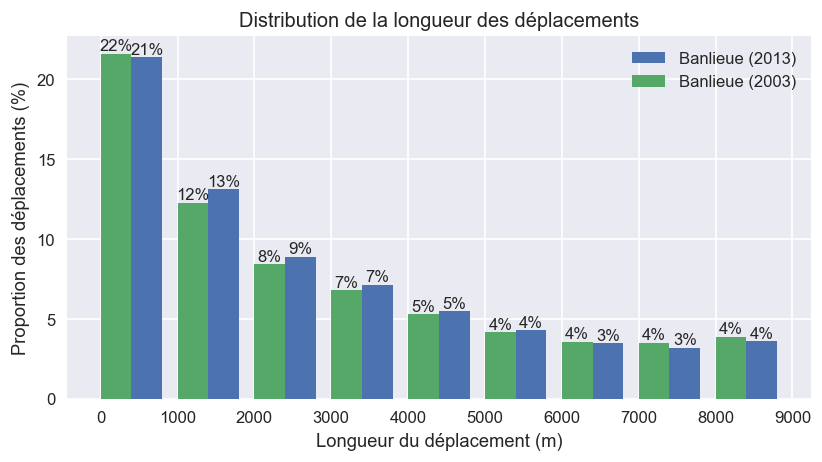

In [396]:
width = 400
plt.figure(figsize=(8, 4), dpi=120)
def dist_plot(df, title, offset):
    total_facper = df.facper.sum()

    bin_edges = np.arange(0, 10 * 1000, 1000)
    bins = np.histogram(list(df.trip_distance), bins=bin_edges, weights=df.facper / total_facper * 100)[0]
    print(sum(bins))
    bar = plt.bar(bin_edges[:-1]+width-offset, bins, width=width, align="center", label=title)
    plt.bar_label(bar, fmt="%.0f%%")
    _ = plt.xticks(bin_edges)
    plt.xlabel("Longueur du déplacement (m)")
    plt.ylabel("Proportion des déplacements (%)")
    plt.title("Distribution de la longueur des déplacements")
dist_plot(suburb_2013, title="Banlieue (2013)", offset=-width/2)
dist_plot(suburb_2003, title="Banlieue (2003)", offset=width/2)
plt.legend()




<AxesSubplot:>

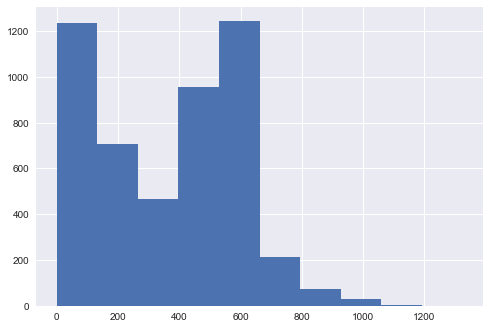

In [240]:
q.ch_duree.hist()

In [242]:
np.arange(0, 900, 60)

array([  0,  60, 120, 180, 240, 300, 360, 420, 480, 540, 600, 660, 720,
       780, 840])

In [279]:
q = suburb_2013[suburb_2013["f_chaine"] == 'T']

In [284]:
q.groupby(pd.cut(df["age"], np.arange(0, 100, 10)))["ch_duree"].mean()

age
(0, 10]     335.183432
(10, 20]    352.691057
(20, 30]    356.924686
(30, 40]    327.491071
(40, 50]    318.362550
(50, 60]    333.455662
(60, 70]    333.598726
(70, 80]    325.594771
(80, 90]    303.977778
Name: ch_duree, dtype: float64

In [289]:
q.groupby(pd.cut(df["age"], np.arange(15, 100, 10)))["permis"]

In [300]:
q[q["permis"] == 1].groupby(pd.cut(q["age"], np.arange(15, 100, 5))).sum()["facper"] / q.groupby(pd.cut(q["age"], np.arange(15, 100, 5))).sum()["facper"]

age
(15, 20]    0.590232
(20, 25]    0.883603
(25, 30]    0.892432
(30, 35]    0.952002
(35, 40]    0.969823
(40, 45]    0.956965
(45, 50]    0.976415
(50, 55]    0.987471
(55, 60]    0.972941
(60, 65]    0.941460
(65, 70]    0.955075
(70, 75]    0.931860
(75, 80]    0.829321
(80, 85]    0.698133
(85, 90]    0.601937
(90, 95]    0.000000
Name: facper, dtype: float64